# Bird richness data preprocessing

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pooch
import rasterio as rio
from rasterio import mask, plot

In [ ]:
# species richness dataset
species_richness_filepath = (
    "https://www.envidat.ch/dataset/0f81429a-204e-4720-929e-5b251e9ab1c4/resource/"
    "f3abc8d4-c92e-4a57-aea4-39ba8c93158d/download/dataset_5_species_richness_all.txt"
)

# actual notebook parameters
# we only need the largest buffer here
# buffer_dists = [100, 250, 500, 1000]
buffer_dist = 1000
# aggregate from 72 base classes to the 4 main domains (urban, agricultural, forest and
# improductive areas) plus a separate class for urban green spaces.
# see https://www.bfs.admin.ch/bfs/fr/home/statistiques/espace-environnement/nomenclatures/arealstatistik.html
# bins = [1, 3, 15, 24, 31, 37, 41, 42, 45, 50, 57, 58, 61, 62, 64, 69, 72]
bins = [1, 31, 37, 50, 61]

# LULC dataset
lulc_url = (
    "https://access.yareta.unige.ch/accession/access/metadata/"
    "6ab4b715-904f-4cb9-961c-6a25b4c1116b/download"
)
known_hash = "699d94ddd77d2921eb40128fcfc2da05586c11eb4a32e39810e874259893bb69"
members = [
    f"data/6ab4b715-904f-4cb9-961c-6a25b4c1116b/researchdata/LU-CH/LU-CH_2018all.{ext}"
    for ext in ["tif", "tfw"]
]

# output files
dst_bird_richness_filepath = "../data/processed/bird-richness.gpkg"
dst_lulc_filepath = "../data/processed/bird-richness-lulc.tif"
dst_nodata = 0

## Species richness data

Casanelles et al. (2021) [1]

In [ ]:
bird_gdf = pd.read_csv(species_richness_filepath, sep="\t")
bird_gdf = bird_gdf[bird_gdf["GROUP"] == "Birds"]
bird_gdf = gpd.GeoDataFrame(
    bird_gdf, geometry=gpd.points_from_xy(bird_gdf["X"], bird_gdf["Y"]), crs="epsg:2056"
)
bird_gdf.head()

,SITE_FULL,GROUP,n.species,X,Y,conn.cov.ra.adj,conn.p95.ra.adj,lc.masked.zh,LiDAR.1m.cov.adj,LiDAR.1m.p95.adj,...,ZH_landcover_join_class_water_agg50m,ZH_landcover_join_class_wood_agg100m,ZH_landcover_join_class_wood_agg10m_dist,ZH_landcover_join_class_wood_agg10m,ZH_landcover_join_class_wood_agg200m,ZH_landcover_join_class_wood_agg20m,ZH_landcover_join_class_wood_agg50m,w,PROJEKTABK,geometry
1193,BiodiverCity_1,Birds,13,2679508.900,1248007.863,9.962126e-04,6.678452e-04,6,3.783488e-04,1.783894e-05,...,0.0,1061.900024,1.000000,1.303852e-09,3679.235107,181.125,364.000000,1,Bi,POINT (2679508.9 1248007.863)
1201,BiodiverCity_10,Birds,19,2679869.891,1246748.864,7.115819e-07,2.512636e-07,6,1.764584e-13,2.296624e-14,...,0.0,517.580017,6.082763,0.000000e+00,31791.759766,0.000,0.000000,1,Bi,POINT (2679869.891 1246748.864)
1209,BiodiverCity_11,Birds,15,2680192.897,1246868.860,7.106683e-04,4.500271e-04,6,4.336690e-14,3.080652e-15,...,0.0,562.275024,8.000000,0.000000e+00,13774.599609,0.000,0.000000,1,Bi,POINT (2680192.897 1246868.86)
1217,BiodiverCity_12,Birds,24,2680284.893,1246246.860,1.219931e-03,5.290124e-04,6,3.363727e-14,5.365604e-15,...,0.0,843.114990,5.656854,0.000000e+00,4419.572266,0.000,117.599998,1,Bi,POINT (2680284.893 1246246.86)
1225,BiodiverCity_13,Birds,16,2680508.891,1246128.858,1.341395e-03,1.335816e-03,6,1.706169e-08,1.607228e-09,...,0.0,4674.075195,3.162278,0.000000e+00,26349.837891,0.000,70.000000,1,Bi,POINT (2680508.891 1246128.858)


## Land use/land cover map

Giuliani et al. (2022) [2]

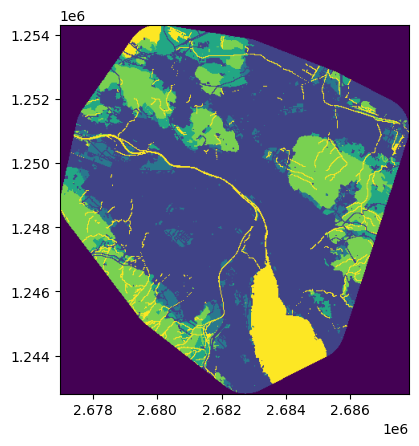

In [ ]:
lulc_filepaths = pooch.retrieve(
    lulc_url, known_hash=known_hash, processor=pooch.Unzip(members=members)
)
lulc_filepath = list(filter(lambda str: str.endswith(".tif"), lulc_filepaths))[0]

with rio.open(lulc_filepath) as src:
    img, transform = mask.mask(
        src,
        [bird_gdf.to_crs(src.crs).union_all().convex_hull.buffer(buffer_dist)],
        crop=True,
    )
    meta = src.meta.copy()

    # aggregate classes
    img = np.digitize(np.where(img != src.nodata, img, dst_nodata), np.array(bins))

    # plot
    plot.show(img, transform=transform)

## Save processed data

In [ ]:
bird_gdf.to_file(dst_bird_richness_filepath)

meta.update(
    transform=transform,
    height=img.shape[1],
    width=img.shape[2],
    nodata=dst_nodata,
)
with rio.open(dst_lulc_filepath, "w", **meta) as dst:
    dst.write(np.where(img != src.nodata, img, 0))


## References

1. Casanelles-Abella, J., Chauvier, Y., Zellweger, F., Villiger, P., Frey, D., Ginzler, C., ... & Pellissier, L. (2021). Applying predictive models to study the ecological properties of urban ecosystems: A case study in Zürich, Switzerland. Landscape and Urban Planning, 214, 104137.
2. Giuliani, G., Rodila, D., Külling, N., Maggini, R., & Lehmann, A. (2022). Downscaling Switzerland land use/land cover data using nearest neighbors and an expert system. Land, 11(5), 615.